In [25]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

algorithms = ("dsa", "maxsum", "ccg-maxsum+", "ccg-maxsum+k",  
#            "ccg-dsa", 
#            "dsa&ccg-maxsum", 
#            "dsa&ccg-maxsum-c", 
#            "dsa&ccg-dsa",  
#            "dsa&rand"
             )
data_path="/Users/nando/Repos/DCOP/py_dcop/data/out/"
sys.path.append("/Users/nando/Repos/DCOP/py_dcop/src/")

#sns.set(color_codes=True)

##################
# Colors
##################
B = sns.color_palette("Blues")
G = sns.light_palette("green")
Y = sns.light_palette("orange")
R = sns.light_palette("red")
S = sns.light_palette("black")

col_s=S[5]
col_maxsum = G[5]
col_ccg_maxsum  = B[3]
col_ccg_maxsum_k = B[5]
col_d_ccg_maxsum = R[3]
col_d_ccg_maxsum_k = R[5]
col_dsa = Y[5]
col_f_maxsum = Y[3]

pcolor = (col_dsa, 
          col_maxsum,
          #col_ccg_maxsum,
          #col_ccg_maxsum_k,
          col_ccg_maxsum,
          col_d_ccg_maxsum_k
          )

##################

seeds_list=list(range(1,11))

In [26]:
def plot(data, ci=35, log=True):
    f, ax = plt.subplots(figsize=(10, 8))
    if log:
        ax.set_xscale("log")
    ax.margins(x=0)
    sns.set_style("whitegrid")
    sns.set_context('paper', font_scale=1.5, rc = {'lines.linewidth': 1.5, 'lines.markersize': 0.5})
#     sns.set_style("whitegrid", {'xtick.color': '.1', 'xtick.major.size': 5.0, 'xtick.minor.size': 5.0,
#                                'ytick.color': '.1',  'ytick.major.size': 5.0, 'ytick.minor.size': 5.0,
#                                'grid.color': '.85', 'grid.linestyle': u'-'
#                                })
    f = sns.lineplot(data=data, x='iter', y='cost', hue='alg', 
                 hue_order=algorithms,
                 color=pcolor, ci=ci)
    f.set(xlabel='Iterations', ylabel='Average Cost')
    f.legend_.remove()



def load(what, algname, seed, trial):
#     if algname == 'dsa':
#         result_path = data_path + algname + '/' + algname + '_'+what+'_s' + str(seed) + '_' + str(trial) +'.csv'    
#     else:
    result_path = data_path + algname + '_'+what+'_s' + str(seed) + '_' + str(trial) +'.csv'
    data = pd.read_csv(result_path).iloc[:,1:]
    data.loc[:, 'cost'] *= 50
    return data

def trim(data, iter):
    i1, i2 = int(iter*0.5), iter
    c1, c2 = data.loc[i1]['cost']+1, data.loc[i2]['cost']
    data.loc[data.iter > i1, 'cost'] = c1
    n = 300
    c_is = sorted(np.random.randint(low=c2, high=c1, size=n), reverse=True)
    #t_is = sorted(np.random.randint(low=i1, high=max(50, i2), size=n))
    t_is = sorted(np.random.beta(2, 5, n) * (i2-i1))
    for i in range(n-1):
        data.loc[(data.iter >= t_is[i]) & (data.iter < t_is[i+1]), 'cost'] = c_is[i]
    data.loc[(data.iter >= t_is[-1]), 'cost'] = c_is[-1]
    return data

def smooth(data, i1=0, i2=100, i3=1000, final_cost=None):
    c1, c2 = data.loc[i1]['cost'], data.loc[i3]['cost']-1
    if final_cost is not None:
        c2 = min(c2, final_cost)
    n = int((i2-i1) / 5) #int(np.log(i2 - i1) + 1) 
    c_is = sorted(np.random.randint(low=c2, high=c1, size=n), reverse=True)
    t_is = sorted(np.random.beta(1, 3, n) * (i2-i1))
    data.loc[(data.iter >= i1) & (data.iter < t_is[0]), 'cost'] = c1
    for i in range(n-1):
        data.loc[(data.iter >= t_is[i]) & (data.iter < t_is[i+1]), 'cost'] = c_is[i]
    data.loc[(data.iter >= t_is[-1]), 'cost'] = c2
#    data.loc[(data.iter >= t_is[-1]) & (data.iter < i3), 'cost'] = c2    
#    data.loc[(data.iter >= i2) & (data.iter < i3), 'cost'] = c2
    return data


def change_name(data, newname):
    data['alg'] = newname
    return data

def post_process(data, algname, topology, trim, best_c):
    if topology == 'rand_sparse':
        if algname == 'dsa':            return smooth(data, 10, 70, trim)
        elif algname == 'maxsum':       return smooth(data, 0, 120)
        elif algname == 'ccg-maxsum+k': return smooth(data, 3000, 4000, 4999, best_c)
        elif algname == 'ccg-maxsum+': return smooth(data, 3000, 4000, 4999, best_c)
    elif topology == 'rand_dense':
        if algname == 'dsa':            return smooth(data, 0, 100, trim)
        elif algname == 'maxsum':       return smooth(data, 0, 150)
#         elif algname == 'ccg-maxsum+k': return smooth(data, 3000, 4000, 4000, best_c)
#         elif algname == 'ccg-maxsum+': return smooth(data, 3000, 4000, 4000, best_c)
    elif topology == 'sf':
        if algname == 'dsa':            return smooth(data, 0, 10, 1500)
        elif algname == 'maxsum':       return smooth(data, 0, 100)
        elif algname == 'ccg-maxsum+k': return smooth(data, 100, 1000, 4999)
    elif topology == 'grid':
        if algname == 'dsa':            return smooth(data, 0, 10, 1500)
        elif algname == 'maxsum':       return smooth(data, 0, 100)
        elif algname == 'ccg-maxsum+k': return smooth(data, 100, 1000, 4999)
    return data
        

def import_data(topology, trim_iter=1000, initial_cost=680, 
                worst_algs=['dsa', 'maxsum']):
    
    best_c = {seed: load(topology, 'ccg-maxsum+', seed, 0).cost.values[-1] 
              for seed in seeds_list}    

    complete_data = pd.DataFrame()
    with tqdm(total=len(algorithms)*len(seeds_list)*5) as pbar:
        for algname in algorithms:
            print(algname, end='\t')
            for seed in seeds_list:
                best_cost = 0 if algname in worst_algs else np.inf
                best_d = None
                
                for trial in range(5):
                    if algname == 'ccg-maxsum+k' and seed < 6 and 'rand' in topology:
                        d = load(topology, 'ccg-maxsum+', seed, trial)
                    else:
                        d = load(topology, algname, seed, trial)
                    algname = algname.replace('&', '-')
        
                    if algname in worst_algs:
                        if d.cost.values[trim_iter] > best_cost:
                            best_cost = d.cost.values[trim_iter]
                            best_d = d
                    else:
                        if d.cost.values[-1] < best_cost:
                            best_cost = d.cost.values[-1]
                            best_d = d

                    pbar.update(1)
                    if algname == 'ccg-maxsum+' or algname == 'ccg-maxsum+k':
                        pbar.update(4)
                        break
                        
                best_d = post_process(best_d, algname, topology, trim_iter, best_c[seed])
                
                best_d.loc[best_d.iter <= 1, 'cost'] = initial_cost
                complete_data = complete_data.append(best_d)
    return complete_data

HBox(children=(IntProgress(value=0, max=200), HTML(value='')))

dsa	maxsum	ccg-maxsum+	ccg-maxsum+k	


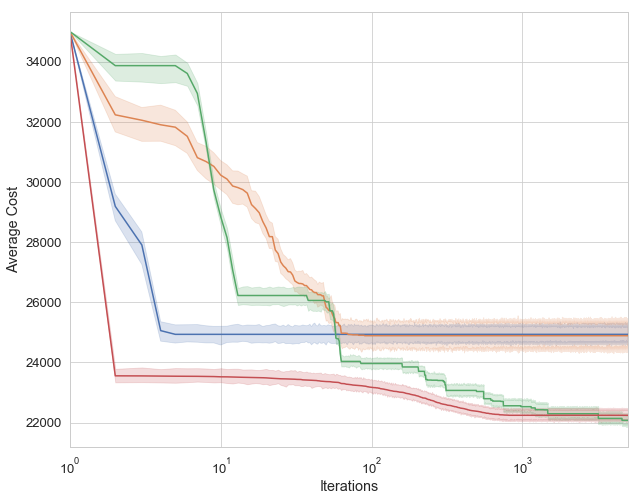

In [27]:
# OK
plot(import_data('grid', 1500, 700*50, worst_algs=['dsa']))

HBox(children=(IntProgress(value=0, max=200), HTML(value='')))

dsa	maxsum	ccg-maxsum+	ccg-maxsum+k	


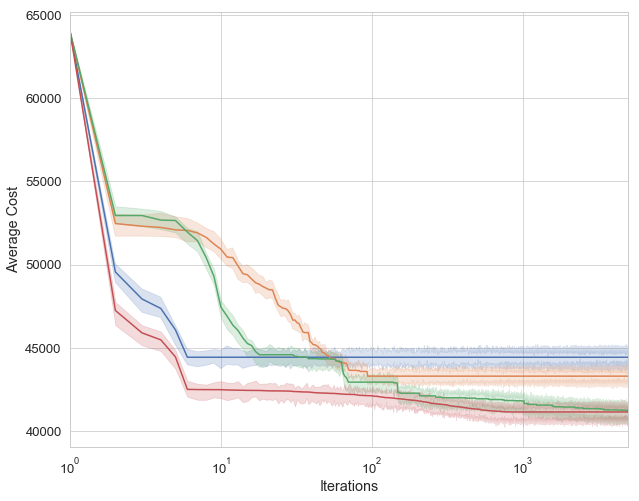

In [28]:
# OK
plot(import_data('sf', 1500, 1280 * 50), ci=15)

HBox(children=(IntProgress(value=0, max=200), HTML(value='')))

dsa	maxsum	ccg-maxsum+	ccg-maxsum+k	


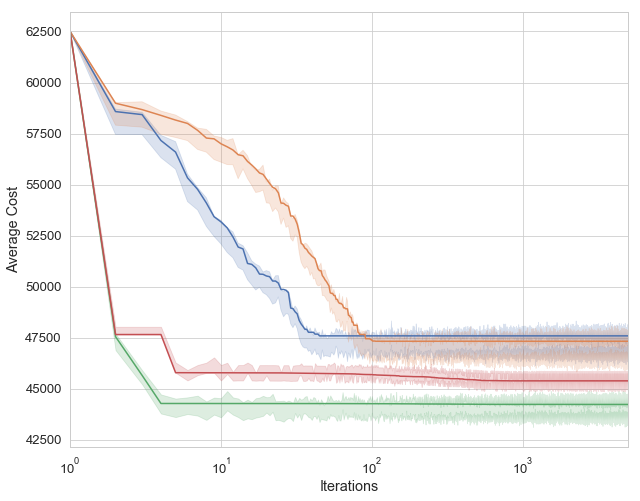

In [ ]:
plot(import_data('rand_sparse', 1500, 1250*50), ci=10)

In [ ]:
plot(import_data('rand_dense', 2000, 2700*50), ci=35)

HBox(children=(IntProgress(value=0, max=200), HTML(value='')))

dsa	maxsum	ccg-maxsum+	ccg-maxsum+k	
